# Advection-Diffusion-Reaction Model

This notebook demonstrates how to
- Define the equation you want to solve
- Setup up and initial-boundary value problem
- Choose a particular set of numerics
- Post-process the solution

$
\newcommand{\grad}{\nabla}
$

In [1]:
%matplotlib notebook
from proteus.iproteus import * 
Profiling.logLevel=7
Profiling.verbose=False

# Defining an equation
The equation we want to solve is
\begin{equation*}
m_t + \nabla \cdot \left(\mathbf{f} - \mathbf{a} \grad u \right) + r = 0
\end{equation*}
where $u$ is the unknown solution and the coefficients have the specific  forms
\begin{align}
m(u) &= M u \\
f(u) &= \mathbf{B} u \\
a(u) &= \mathbf{A} \\
r(u) &= C u \\
\end{align}

# Proteus template equation
\begin{equation}
\mathbf{u} = \left[ u^0,u^1,\ldots,u^{nc-1} \right]
\end{equation}
\begin{equation*}
m^i_t + \nabla \cdot \left(\mathbf{f}^i - \sum_k^{nc-1} \mathbf{a}^{i,k} \nabla \phi^k(\mathbf{u}) \right) + r^i + H^i(\nabla u^i)= 0 \qquad \mbox{for } i=0,\ldots,nc-1
\end{equation*}

- $m$ is "mass"
- $\mathbf{f}$ is advection
- $\mathbf{a}$ is diffution
- $\phi$ is potential
- $H$ is Hamiltonian
- $r$ is reaction

Example: non-conservative advection
\begin{equation}
u_t + \mathbf{v} \cdot \nabla u = 0
\end{equation}

What is $m$?
What is $f$?
What is $H$?

In [2]:
class LADR(TransportCoefficients.TC_base):
    """
    The coefficients of the linear advection-diffusion equation
    """
    def __init__(self,M,A,B,C):
        TransportCoefficients.TC_base.__init__(self,
                                               nc=1, #number of components
                                               variableNames=['u'],
                                               mass      = {0:{0:'linear'}},
                                               advection = {0:{0:'linear'}},
                                               diffusion = {0:{0:{0:'constant'}}},
                                               potential = {0:{0:'u'}},
                                               reaction  = {0:{0:'linear'}})
                                            
        self.M=M;
        self.A=A;
        self.B=B;
        self.C=C;
    def evaluate(self,t,c):
        c[('m',0)][:]         = self.M*c[('u',0)]  
        c[('dm',0,0)][:]      = self.M
        c[('f',0)][...,0]     = self.B[0]*c[('u',0)]
        c[('f',0)][...,1]     = self.B[1]*c[('u',0)]
        c[('df',0,0)][...,0]  = self.B[0]
        c[('df',0,0)][...,1]  = self.B[1]
        c[('a',0,0)][...,0] = self.A[0][0]
        c[('a',0,0)][...,1] = self.A[0][1]
        c[('a',0,0)][...,2] = self.A[1][0]
        c[('a',0,0)][...,3] = self.A[1][1]
        c[('r',0)][:]         = self.C*c[('u',0)]  
        c[('dr',0,0)][:]      = self.C


# Physics

In [3]:
from proteus import default_p as p
#physics
p.name = "ladr_2d"
p.nd = 2; #Two dimensions
p.L=(1.0,1.0); 
p.T=1.0

p.coefficients=LADR(M=1.0,
                    A=[[1.001,0.0],
                       [0.0,1.001]],
                    B=[0.0,0.0],
                    C=0.0)

def getDBC(x,flag):
    if x[0] == 0.0 or x[1] == 0.0:
        return lambda x,t: 1.0
    elif x[0] == p.L[0] or x[1] == p.L[1]:
        return lambda x,t: 0.0
    else:
        return None
    
p.dirichletConditions = {0:getDBC}
p.advectiveFluxBoundaryConditions = {}
p.diffusiveFluxBoundaryConditions = {0:{}}
p.periodicDirichletConditions = None
class IC:
    def __init__(self):
        pass
    def uOfXT(self,x,t):
        if x[0] <= 0.0 or x[1] <= 0.0:
            return 1.0
        else:
            return 0.0

p.initialConditions  = {0:IC()}

# Numerics

In [4]:
from proteus import default_n as n
import proteus as pr
n.timeIntegration = pr.TimeIntegration.BackwardEuler_cfl
n.stepController = pr.StepControl.Min_dt_cfl_controller
n.runCFL=1.0
n.femSpaces = {0:pr.FemTools.C0_AffineLinearOnSimplexWithNodalBasis}
n.elementQuadrature = pr.Quadrature.SimplexGaussQuadrature(p.nd,3)
n.elementBoundaryQuadrature = pr.Quadrature.SimplexGaussQuadrature(p.nd-1,3)
n.subgridError = pr.SubgridError.AdvectionDiffusionReaction_ASGS(p.coefficients,
                                                                 p.nd,lag=False)
n.shockCapturing = pr.ShockCapturing.ResGradQuad_SC(p.coefficients,
                                                    p.nd,
                                                    shockCapturingFactor=0.99,
                                                    lag=True)
n.numericalFluxType = pr.NumericalFlux.Advection_DiagonalUpwind_Diffusion_SIPG_exterior
n.nnx=41; n.nny=41
n.tnList=[float(i)/40.0 for i in range(11)]
n.matrix = pr.LinearAlgebraTools.SparseMatrix
n.multilevelLinearSolver = pr.LinearSolvers.KSP_petsc4py
n.l_atol_res = 1.0e-8
n.parallelPartitioningType = pr.MeshTools.MeshParallelPartitioningTypes.element
n.nLayersOfOverlapForParallel = 1
n.periodicDirichletConditions = None

# Operator Splitting

In [5]:
from proteus import default_s,default_so
so = default_so
so.name = p.name 
so.sList=[default_s]
so.tnList = n.tnList
so.systemStepControllerType = SplitOperator.Sequential_FixedStep_Simple
so.systemStepExact= False
so.dt_system_fixed= 0.01

# Initialize Numerical Solution Object

In [6]:
ns = NumericalSolution.NS_base(so,[p],[n],so.sList,opts)

# Calculate Solution

In [7]:
failed = ns.calculateSolution('ladr_run1')
assert(not failed)

<IPython.core.display.Javascript object>


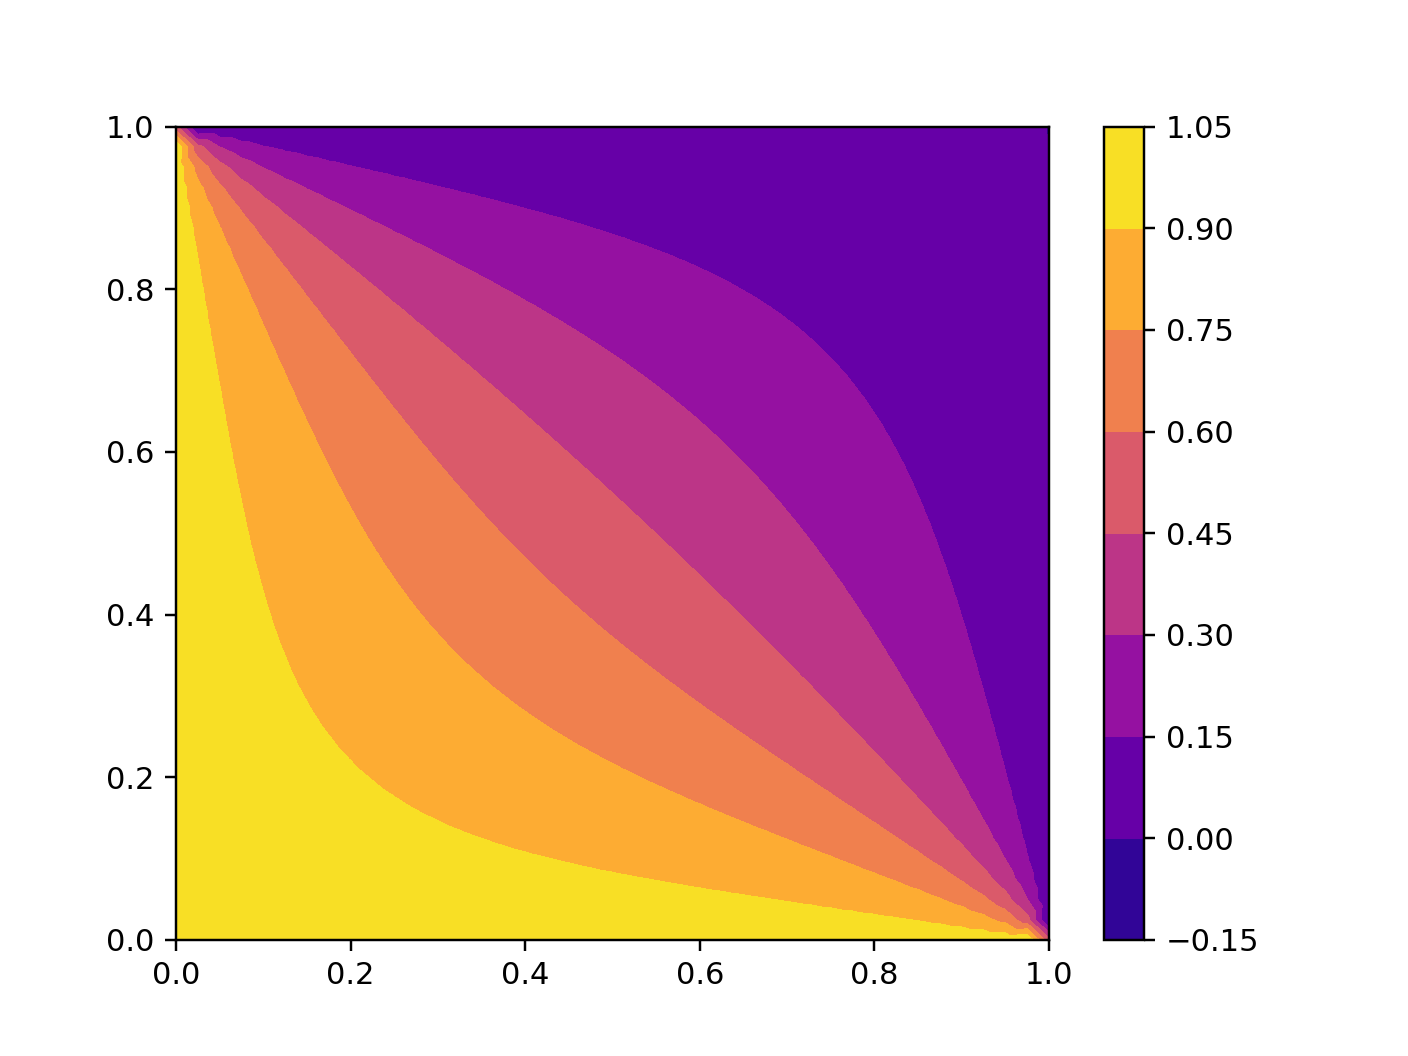

In [8]:
from matplotlib import pyplot as plt
x = ns.modelList[0].levelModelList[-1].mesh.nodeArray[:,0]
y = ns.modelList[0].levelModelList[-1].mesh.nodeArray[:,1]
triangles = ns.modelList[0].levelModelList[-1].mesh.elementNodesArray
u = ns.modelList[0].levelModelList[-1].u[0].dof
plt.set_cmap('plasma')
plt.tricontourf(x,y,triangles,u)
plt.colorbar()
plt.show()

[proteus.log](proteus.log)